# Overview

 - Runs prediction of specified model on images in samples folder
 - Ensure images added to samples folder have white background with black pen
 - Model architecture defined in models/cnn_base.py
 - Model checkpoint loaded from ocr_letters.pth

In [6]:
import sys
sys.path.append("../")
import torch
import json
from PIL import Image
from torchvision import transforms
from models.cnn_base import CNNBaseModel
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# import wavemix    # Model architecture I was testing -- seems to do better but definitely needs gpu to train
# from wavemix.classification import WaveMix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_CKPT = Path("model_ckpts/ocr_letters.pth")
CLASS_MAP = Path("emnist_letters_map.json")

with open(str(CLASS_MAP), 'r') as file:
    class_map = json.load(file)

model = CNNBaseModel()


In [7]:

model.load_state_dict(torch.load(str(MODEL_CKPT), map_location=device)) #When loading model from weights make sure it matches the specified architecture
model.eval()

def prep_img_for_model(model, img_path):
    """
    img_path is pathlib Path object
    Processes input image (Black pen, white background)
    Returns image tensor formatted for given model
        Resized - 28x28
        Inverted colors
    """
    image = Image.open(str(img_path)).convert('L')
    image = Image.eval(image, lambda x: 255 - x) #Invert colors

    transform = transforms.Compose([    #Resize for model and convert to tensor
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])
    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze(0)

    # if isinstance(model, WaveMix):
    #     image_tensor = image_tensor.repeat(1,3,1,1)
    
    return image_tensor

def get_class(class_num): #Convert model's number prediction to letter prediction
    return class_map[str(class_num - 1)]

In [8]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import gzip

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Helper function to load MNIST-like .gz files
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
        return data.reshape(-1, 28, 28)  # Shape: (num_samples, 28, 28)

def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        return np.frombuffer(f.read(), np.uint8, offset=8)  # Shape: (num_samples,)

# Define paths to the extracted files
train_images_path = 'emnist_data/gzip/emnist-letters-train-images-idx3-ubyte.gz'
train_labels_path = 'emnist_data/gzip/emnist-letters-train-labels-idx1-ubyte.gz'
test_images_path = 'emnist_data/gzip/emnist-letters-test-images-idx3-ubyte.gz'
test_labels_path = 'emnist_data/gzip/emnist-letters-test-labels-idx1-ubyte.gz'

# Load the data
train_images = load_mnist_images(train_images_path)
train_labels = load_mnist_labels(train_labels_path)
test_images = load_mnist_images(test_images_path)
test_labels = load_mnist_labels(test_labels_path)

# Create a custom PyTorch dataset
class EMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)  # Apply transformations
        return image, label

# Create datasets
train_dataset = EMNISTDataset(train_images, train_labels, transform=transform)
test_dataset = EMNISTDataset(test_images, test_labels, transform=transform)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Iterate through the training data
for images, labels in train_loader:
    print(images.shape)  # Output: (batch_size, 1, 28, 28)
    print(labels.shape)  # Output: (batch_size,)
    break  # Just to see one batch


torch.Size([64, 1, 28, 28])
torch.Size([64])


In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    # transforms.Resize((256, 256))
])

# Load EMNIST letters dataset
data_root = './data'
emnist_data = datasets.EMNIST(root=data_root, split='letters', train=True, download=True, transform=transform)
train_loader = DataLoader(emnist_data, batch_size=64, shuffle=True)


100%|██████████| 110115/110115 [00:00<00:00, 677055.01it/s]


RuntimeError: File not found or corrupted.

### Evaluation Notes

 - Below code generates evaluation diagram by displaying the predictions above each letter
 - Left most letter is highest confidence, the right side ones are lower confidence

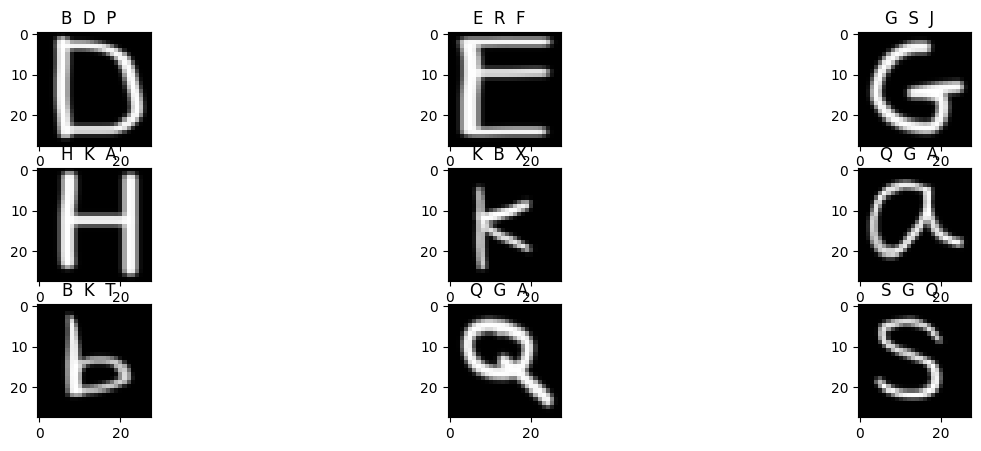

In [16]:
LETTERS_DIR = Path("samples/letters/")
fig, axs = plt.subplots(4, 4, figsize=(15, 5))
for ind, img in enumerate(LETTERS_DIR.iterdir()):
    image_tensor = prep_img_for_model(model, str(img))

    with torch.no_grad():
        output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)

    _, top3 = torch.topk(output, 3)
    top3 = top3.flatten().tolist()
    
    top3_preds = ''
    for pred in top3:
        top3_preds += f"{get_class(pred)}  "
    

    axs[ind // 3, ind % 3].imshow(image_tensor.squeeze(0).squeeze(0), cmap='gray')
    axs[ind // 3, ind % 3].set_title(top3_preds)
    # axs[ind // 3, ind % 3].set_title(get_class(predicted_class.item()))

    

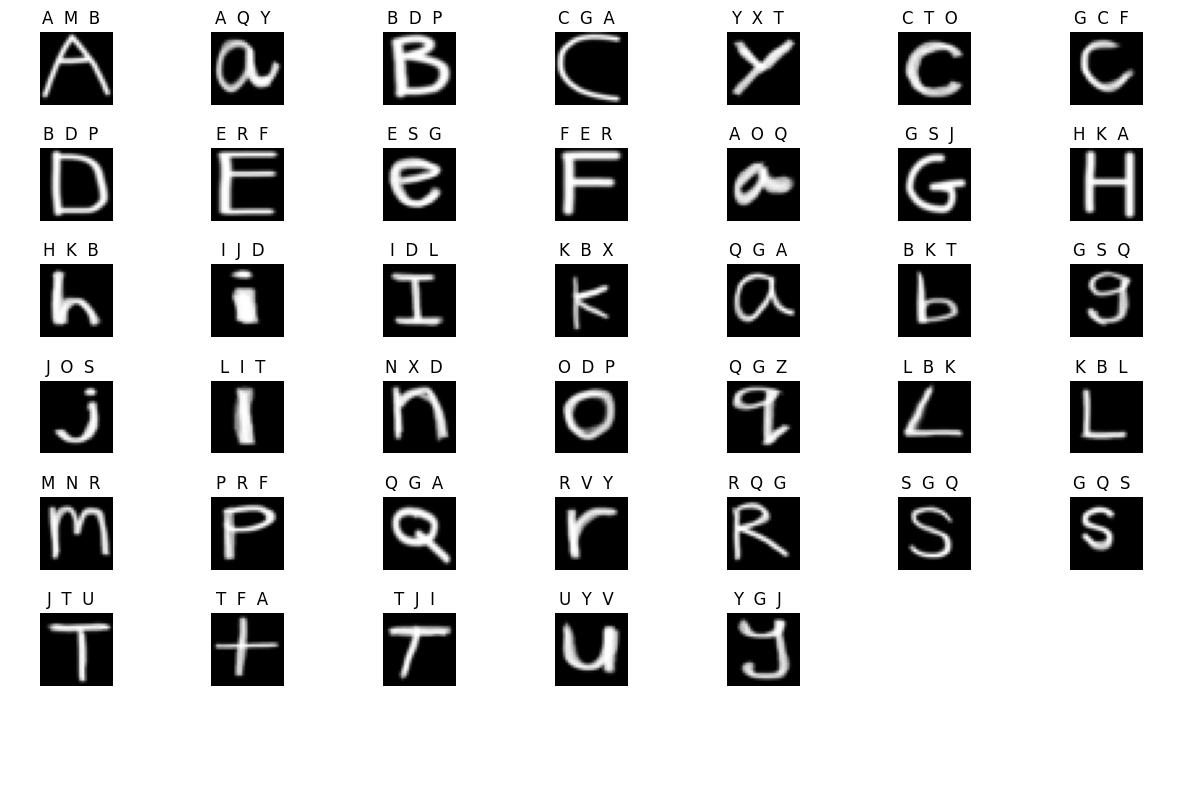

In [24]:
import matplotlib.pyplot as plt
import torch
from pathlib import Path

LETTERS_DIR = Path("samples/letters/")
fig, axs = plt.subplots(7, 7, figsize=(15, 10))  # Adjust the grid size to 5x5
plt.subplots_adjust(hspace=0.6, wspace=0.3)  # Increase space between rows and columns

for ind, img in enumerate(LETTERS_DIR.iterdir()):
    if ind >= 49:  # Limit the number of images to the grid size (5x5 = 25)
        break
    
    image_tensor = prep_img_for_model(model, str(img))

    with torch.no_grad():
        output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)

    _, top3 = torch.topk(output, 3)
    top3 = top3.flatten().tolist()

    top3_preds = ''
    for pred in top3:
        top3_preds += f"{get_class(pred)}  "

    axs[ind // 7, ind % 7].imshow(image_tensor.squeeze(0).squeeze(0), cmap='gray')
    axs[ind // 7, ind % 7].set_title(top3_preds)
    axs[ind // 7, ind % 7].axis('off')  # Optional: Turn off axis for cleaner look

# Optional: Hide unused subplots if there are fewer images than grid spaces
for ax in axs.flatten()[ind+1:]:
    ax.axis('off')

plt.show()


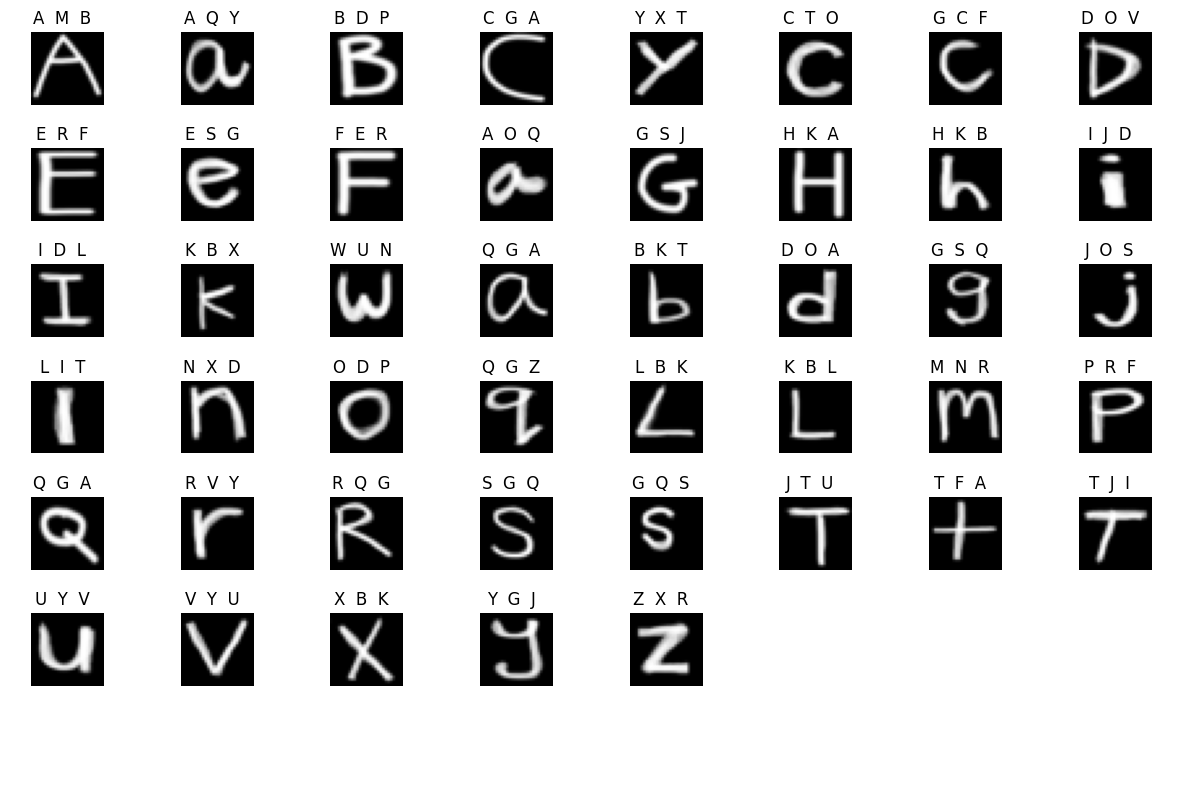

In [28]:
import matplotlib.pyplot as plt
import torch
from pathlib import Path

LETTERS_DIR = Path("samples/letters/")
fig, axs = plt.subplots(7, 8, figsize=(15, 10))  # Grid size 7x8
plt.subplots_adjust(hspace=0.6, wspace=0.3)  # Increase space between rows and columns

for ind, img in enumerate(LETTERS_DIR.iterdir()):
    if ind >= 54:  # Limit the number of images to 54
        break
    
    image_tensor = prep_img_for_model(model, str(img))

    with torch.no_grad():
        output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)

    _, top3 = torch.topk(output, 3)
    top3 = top3.flatten().tolist()

    top3_preds = ''
    for pred in top3:
        top3_preds += f"{get_class(pred)}  "

    axs[ind // 8, ind % 8].imshow(image_tensor.squeeze(0).squeeze(0), cmap='gray')
    axs[ind // 8, ind % 8].set_title(top3_preds)
    axs[ind // 8, ind % 8].axis('off')  # Optional: Turn off axis for cleaner look

# Hide unused subplots if there are fewer images than grid spaces (2 empty spots)
for ax in axs.flatten()[ind+1:]:
    ax.axis('off')

plt.show()
